In [ ]:
from local.test import *
from local.basics import *
from local.callback.all import *
from local.vision.all import *

In [ ]:
from local.notebook.showdoc import *

# Tutorial: Training a model on Imagenette

> Regular training with square images and rectangular training

## Square training

### Loading the data with `DataSource`

To load the data with the medium-level API `DataSource`, we need to gather all the images and define some way to split them between training and validation sets.

In [ ]:
source = untar_data(URLs.IMAGENETTE_160)
items = get_image_files(source)
split_idx = GrandparentSplitter(valid_name='val')(items)

Then we detail the type transforms (applied to the items to form a tuple) and the dataset transforms. For our inputs we use `PILImage.create` and for our targets, the `parent_label` function to convert a filename to its class, followed by `Categorize`. We'll also map the wordnet category ids used in Imagenette to words.

The dataset transforms contain data augmentation using PIL and a resize to 128.

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [ ]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize()]]
item_img_tfms = [ToTensor(), FlipItem(0.5), RandomResizedCrop(128, min_scale=0.35)]

We can then pass all of this information to `DataSource`.

In [ ]:
dsrc = DataSource(items, tfms, splits=split_idx)

To convert our `DataSource` to a `DataBunch`, we need to indicate the transforms we want to use at the batch level, here putting on the GPU with `Cuda`, converting the tensors of bytes to float then normalizing using the traditional imagenet statistics.

In [ ]:
batch_tfms = [Cuda(), IntToFloatTensor(), Normalize(*imagenet_stats)]
dbch = dsrc.databunch(after_item=item_img_tfms, after_batch=batch_tfms, bs=64, num_workers=0)

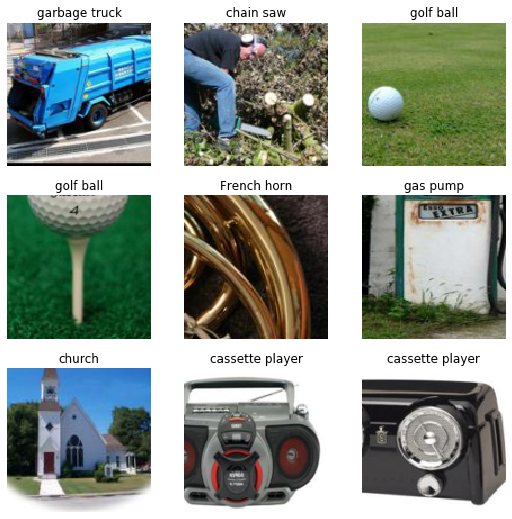

In [ ]:
dbch.show_batch(max_n=9)

### Loading the data with `DataBlock`

An easier way is to use the `DataBlock` higher-level API. We just need to specify the types, how to get the items, how to split them and how to label to build an Imagenette datablock.

In [ ]:
imagenette = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                       get_items=get_image_files, 
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_y=[parent_label,lbl_dict.__getitem__])

We can then directly call the `databunch` method when specifying a source (where the items are) and the non-default dataset and dataloader transforms. To check which transforms are included by default (inferred from the types passed), we can check (and potentially modify) the attributes `default_type_tfms`, `default_item_tfms` and `default_batch_tfms` of the `imagenette` object.

In [ ]:
imagenette.default_type_tfms,imagenette.default_item_tfms,imagenette.default_batch_tfms

((#2) [(#1) [<bound method PILBase.create of <class 'local.vision.core.PILImage'>>],(#1) [Categorize: True (object,object) -> encodes (object,object) -> decodes]],
 (#1) [ToTensor: False (PILMask,object) -> encodes
 (PILBase,object) -> encodes ],
 (#2) [Cuda: False (object,object) -> encodes (object,object) -> decodes,IntToFloatTensor: True (TensorMask,object) -> encodes
 (TensorImage,object) -> encodes (TensorImage,object) -> decodes])

Here we need to add the data augmentation and resize, as well as the normalization.

In [ ]:
dbch = imagenette.databunch(source, bs=64, num_workers=8, item_tfms=item_img_tfms, batch_tfms=Normalize(*imagenet_stats))

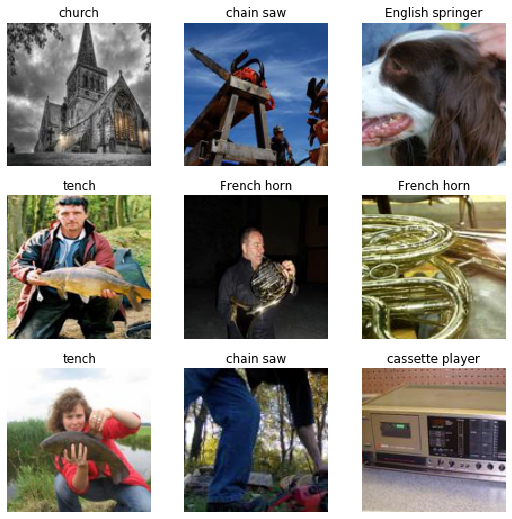

In [ ]:
dbch.show_batch(max_n=9)

### Training

The following function will give us a `Learner` to train a model on imagenette.

In [ ]:
learn = Learner(dbch, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(Adam, wd=0.01, eps=1e-3)
               ).to_fp16()

Then we can train our model.

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,2.178633,2.021364,0.644000,00:17


## Showing results

To get predictions on one item, we use `Learner.predict`

In [ ]:
tst_item = items[0]
t = learn.predict(tst_item)

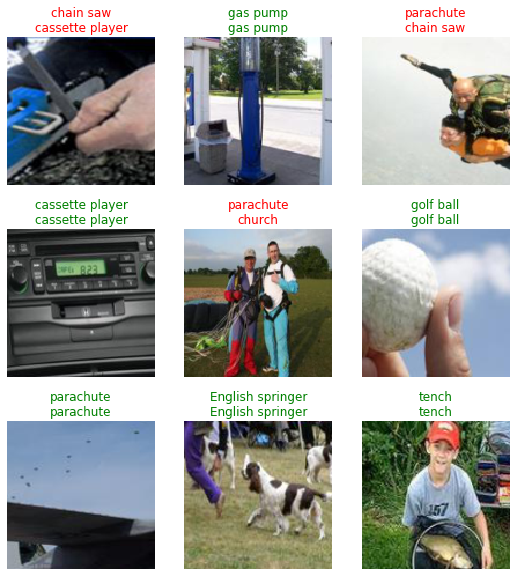

In [ ]:
learn.show_results(max_n=9)

### Side note: using a PyTorch optimizer

In [ ]:
@delegates(torch.optim.AdamW.__init__)
def pytorch_adamw(params, **kwargs):
    return OptimWrapper(torch.optim.AdamW(params, **kwargs))

In [ ]:
learn = Learner(dbch, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3)
               ).to_fp16()

## Rect training (not working well)

For a rectangular training, we change the dataset transforms to use the flip only. We will resize the images when it's time to batch them only.

In [ ]:
#img_tfms = [FlipItem(0.5)]
#tfms = [PILImage.create, [parent_label, Categorize()]]
#dsrc = DataSource(items, tfms, splits=split_idx, item_tfms=img_tfms)

#tfms = [Cuda(), IntToFloatTensor(), Normalize(*imagenet_stats)]
#bs = 64

We use a sampler that will group the images by batches of the close size and aspect ratio (with a bit of shuffle for the training set) and a collation function that will resize them to the mdeian aspect ratio and median number of pixel (bound by `max_px`). `rand_min_scale` is used to do a `RandomResizedCrop` to that size on the training set.

In [ ]:
#samp = SortARSampler(dsrc.train, shuffle=True, bs=bs)
#collate_fn = ResizeCollate(max_px=128*128, rand_min_scale=0.35, rand_ratio_pct=0.33, round_mult=32)
#train_dl = TfmdDL(dsrc.train, tfms, num_workers=8, batch_sampler=samp, collate_fn=collate_fn)

#samp = SortARSampler(dsrc.valid, shuffle=False, bs=bs)
#collate_fn = ResizeCollate(max_px=128*128, round_mult=32)
#valid_dl = TfmdDL(dsrc.valid, tfms, num_workers=8, batch_sampler=samp, collate_fn=collate_fn)

Then we create a `DataBunch` with those two dataloaders.

In [ ]:
#dbch1 = imagenette.databunch(source, bs=64, num_workers=8, item_tfms=item_img_tfms, batch_tfms=Normalize(*imagenet_stats))

#dbch = DataBunch(train_dl, valid_dl)
#dbch.show_batch(max_n=9)

In [ ]:
#learn = cnn_learner(xresnet18, dbch, LabelSmoothingCrossEntropy(), opt_func=opt_func, c_in=3, c_out=10, lr=1e-2, metrics=accuracy)
#learn.fit_one_cycle(1)